#### логистическая регрессия

In [2]:
import os
os.getcwd()

'C:\\Users\\fn-me'

In [29]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Данные
X = np.array([
    [1, 2],
    [2, 1],
    [2, 2]
])
y = np.array([1, 0, 1])

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# L2-регуляризация (Ridge)
model_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
model_l2.fit(X_scaled, y)
y_test_l2 = model_l2.predict_proba(X_scaled)[:,1]
w_l2 = model_l2.coef_

# L1-регуляризация (Lasso)
model_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000)
model_l1.fit(X_scaled, y)
y_test_l1 = model_l1.predict_proba(X_scaled)[:,1]
w_l1 = model_l1.coef_

print("L2 weights:", w_l2)
print("L1 weights:", w_l1)
print("y_test_l1", y_test_l1)
print("y_test_l2", y_test_l2)
precision_score(y,np.where(y_test_l2>=0.5,1,0))

L2 weights: [[-0.29778103  0.7963671 ]]
L1 weights: [[0.         0.57465783]]
y_test_l1 [0.60021102 0.3073178  0.60021102]
y_test_l2 [0.85960559 0.37542313 0.76500696]


1.0

#### линейная регрессия

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)  # alpha — степень регуляризации
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)  # alpha подбирается по кросс-валидации
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # 50% L1, 50% L2
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

NameError: name 'X_train' is not defined

##### дерево решений

In [48]:
# prunning дерева

from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Загружаем данные
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Строим базовое дерево без обрезки
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
print("Accuracy без обрезки:", clf.score(X_test, y_test))


# Обучающее дерево без ограничения
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas  # возможные значения обрезки,значения подбираются после построения дерева
print(ccp_alphas)

Accuracy без обрезки: 0.951048951048951
[0.         0.00232826 0.00312989 0.00459972 0.00596017 0.00794511
 0.01213836 0.01341382 0.01516793 0.01610939 0.02658769 0.02752968
 0.32476748]


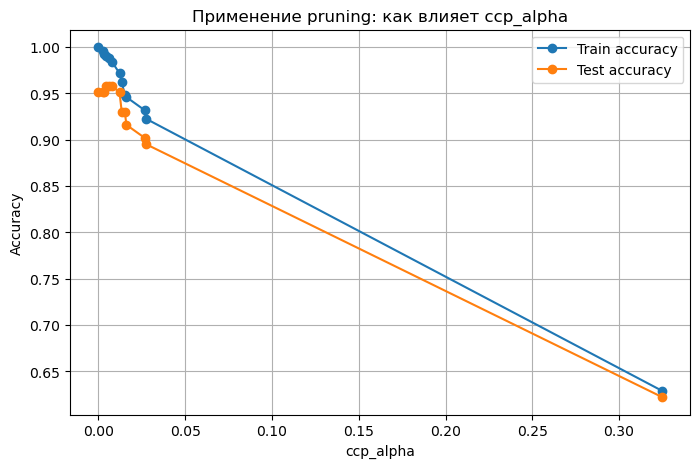

In [50]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(ccp_alphas, train_scores, label="Train accuracy", marker='o')
plt.plot(ccp_alphas, test_scores, label="Test accuracy", marker='o')
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Применение pruning: как влияет ccp_alpha")
plt.grid(True)
plt.show()

In [52]:
# финальное дерево

best_alpha = ccp_alphas[test_scores.index(max(test_scores))]
final_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_tree.fit(X_train, y_train)

print("Лучшая alpha:", best_alpha)
print("Accuracy после pruning:", final_tree.score(X_test, y_test))

Лучшая alpha: 0.004599723778209322
Accuracy после pruning: 0.958041958041958


##### случайный лес

In [ ]:
# можно использовать ансамбль любых моделей

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          n_estimators=100,
                          bootstrap=True)
model.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

# Классификация
clf = ExtraTreesClassifier(n_estimators=100, max_depth=None, random_state=42)
clf.fit(X_train, y_train)

# Регрессия
reg = ExtraTreesRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

#### настройка гиперпараметров

In [ ]:
import optuna
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Загружаем данные
X, y = load_breast_cancer(return_X_y=True)

# Функция, которую будет минимизировать Optuna
def objective(trial):
    # Определяем диапазоны для гиперпараметров
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
    }

    model = xgb.XGBClassifier(**params)

    # Кросс-валидация
    score = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    return score.mean()

# Создаём исследование
study = optuna.create_study(direction="maximize")  # хотим максимизировать accuracy
study.optimize(objective, n_trials=50, timeout=300)  # 50 попыток или 5 минут

# Результаты
print("🥇 Лучшие параметры:")
print(study.best_params)
print("🏆 Лучшая точность (CV):", study.best_value)

In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()

##### кластеризация

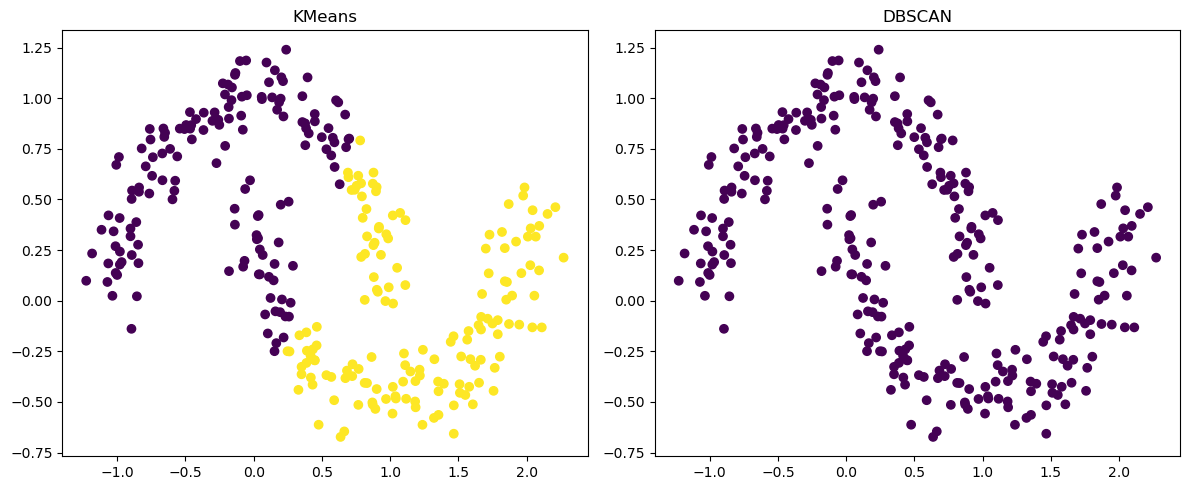

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN

# Сгенерируем игрушечные данные "луны"
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)

# Применим KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Применим DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Визуализация результатов
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis')
axs[0].set_title("KMeans")

axs[1].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis')
axs[1].set_title("DBSCAN")

plt.tight_layout()
plt.show()

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    max_iter=500,
    tol=1e-4,
    random_state=42
)
kmeans.fit(X)

KMeans(max_iter=500, n_clusters=3, n_init=20, random_state=42)

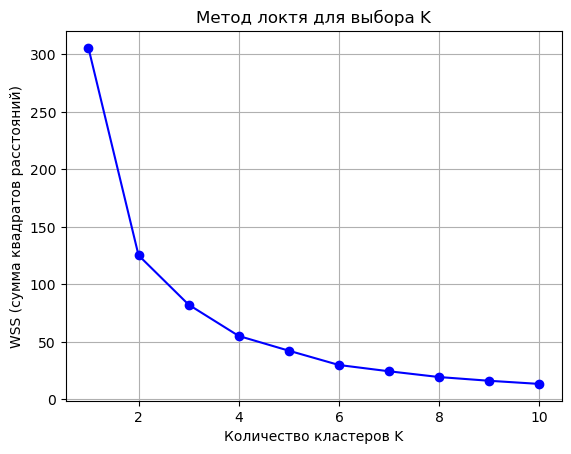

In [8]:
# Посчитаем WSS для разных значений K
wss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)  # inertia_ — это и есть WSS

# Построим график
plt.plot(K_range, wss, 'bo-')
plt.xlabel('Количество кластеров K')
plt.ylabel('WSS (сумма квадратов расстояний)')
plt.title('Метод локтя для выбора K')
plt.grid(True)
plt.show()

In [ ]:
# метрики кластеризации

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
score = silhouette_score(X, labels)
score = davies_bouldin_score(X, labels) 
score = calinski_harabasz_score(X, labels)